#Setup Kaggle

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle


In [3]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!ls ~/.kaggle

kaggle.json


#Import and Extract Wildfire Prediction Dataset

In [6]:
# Download the wildfire prediction dataset
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

# Unzip the downloaded dataset
!unzip wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [7]:
import zipfile

# Set the path to the zip file
zip_file_path = '/content/wildfire-prediction-dataset.zip'

# Set the path to the directory where the contents of the zip file will be extracted
extract_path = '/content/wildfire-prediction-dataset'

# Extract the contents of the zip file to the extract directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


##Import Libraries

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from typing import Iterator, List, Union, Tuple
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History
import tensorflow as tf
import datetime


#Dataset Visualisation

Found 30250 images belonging to 2 classes.


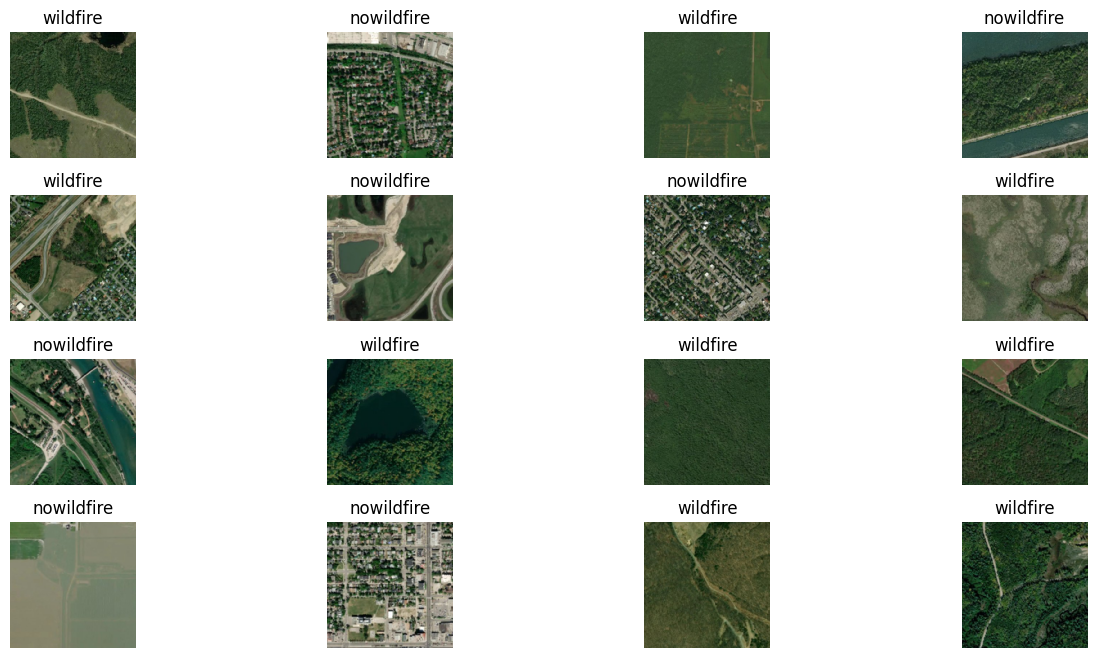

In [9]:
# Define the path to the directory containing the images
data_dir = '/content/train'

# Define the classes
classes = ['nowildfire', 'wildfire']

# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size and image size
batch_size = 16
img_size = (224, 224)

# Generate a batch of images from the dataset
data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    classes=classes,
    class_mode='binary')

# Get a batch of images and their labels
images, labels = next(data)

# Define the figure size and number of columns
fig_size = (16, 8)
num_cols = 4

# Define the figure and axes objects
fig, axs = plt.subplots(batch_size//num_cols, num_cols, figsize=fig_size)

# Loop through the batch of images and display them
for i in range(batch_size):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(images[i])
    axs[row, col].axis('off')
    axs[row, col].set_title(classes[int(labels[i])])
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.1)

# Display the plot
plt.show()


#Dataset Preprocessing

In [10]:
src_path_train = "/content/train/"
src_path_val = "/content/valid/"
src_path_test = "/content/test/"
batch_size = 32

# Applying Guassian Blur
def gaussian_blur(img):
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)  # Apply Gaussian blur with kernel size of 5x5
    return blurred_img

# ImageDataGenerator for Train Data
train_datagen = ImageDataGenerator(
        rescale = 1 / 255.0,
        rotation_range = 30,
        zoom_range = 0.05,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = "nearest",
        preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_data = train_datagen.flow_from_directory(
    directory = src_path_train,
    target_size = (299, 299),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = True,
    seed = 42)

# ImageDataGenerator for Validation Data
val_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                  preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

val_data = val_datagen.flow_from_directory(
    directory = src_path_val,
    target_size = (299, 299),
    color_mode = "rgb",
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = True,
    seed = 42)

# ImageDataGenerator for Test Data
test_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

test_data = test_datagen.flow_from_directory(
    directory = src_path_test,
    target_size = (299, 299),
    color_mode = "rgb",
    batch_size = 1,
    class_mode = "categorical",
    shuffle = True,
    seed = 42)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


#Training the model

#Own Implementation

In [ ]:
#Instantiating a sequential keras model with convolutional layers

model = tf.keras.Sequential([
    
    #Adding convolutional, pooling and batch normalization layers with Xavier Initialisation
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros', input_shape=(64,64,3)),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    #Flattening the convolutional output to a single tensor to be fed into a dense network
    layers.Flatten(),
    
    #Adding dense layers for making final predictions
    layers.Dense(units=128, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.Dense(units=64, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.Dense(units=32, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.Dense(units=16, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.Dense(units=8, activation="relu", kernel_initializer='glorot_uniform', bias_initializer='zeros'),

    #Output layer with two units and softmax activation for prediction
    layers.Dense(units=2, activation="softmax", kernel_initializer='glorot_uniform', bias_initializer='zeros'),

    ])

###Compiling model with Categorical-Crossentropy loss and Adam optimization function

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=['accuracy', 'mse'])

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

###Fitting the model on the defined architecture

In [ ]:
history = model.fit(x=train_data, epochs=30, verbose=1, validation_data=val_data)

Epoch 1/30
946/946 [==============================] - 157s 166ms/step - loss: 0.1810 - accuracy: 0.9286 - mse: 0.0532 - val_loss: 3.1498 - val_accuracy: 0.4641 - val_mse: 0.4975
Epoch 2/30
946/946 [==============================] - 155s 164ms/step - loss: 0.1649 - accuracy: 0.9343 - mse: 0.0482 - val_loss: 0.8806 - val_accuracy: 0.6041 - val_mse: 0.2728
Epoch 3/30
946/946 [==============================] - 156s 165ms/step - loss: 0.1603 - accuracy: 0.9379 - mse: 0.0464 - val_loss: 1.6426 - val_accuracy: 0.5356 - val_mse: 0.3808
Epoch 4/30
946/946 [==============================] - 173s 182ms/step - loss: 0.1546 - accuracy: 0.9413 - mse: 0.0443 - val_loss: 2.3534 - val_accuracy: 0.3640 - val_mse: 0.5393
Epoch 5/30
946/946 [==============================] - 160s 169ms/step - loss: 0.1459 - accuracy: 0.9439 - mse: 0.0420 - val_loss: 1.2851 - val_accuracy: 0.5738 - val_mse: 0.3284
Epoch 6/30
946/946 [==============================] - 164s 173ms/step - loss: 0.1447 - accuracy: 0.9452 - mse:

###Training and Validation Accuracy


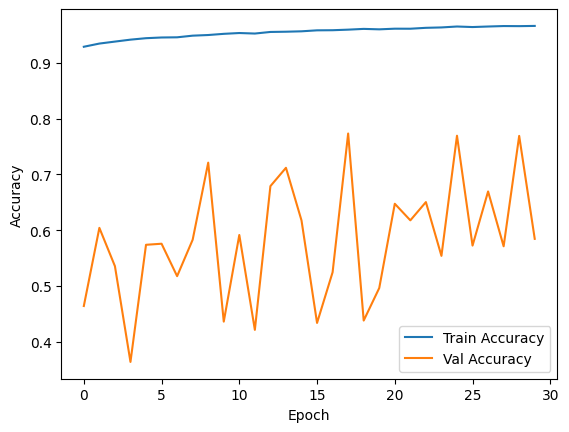

In [ ]:
#Plot training history of the model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='best')
plt.show()

###Testing the Model

In [ ]:
model.evaluate(test_data)

6300/6300 [==============================] - 44s 7ms/step - loss: 2.4989 - accuracy: 0.5870 - mse: 0.3725


[2.4989194869995117, 0.5869840979576111, 0.3724991977214813]

###Confusion Matrix and Classification Report

In [ ]:
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['nowildfire', 'wildfire']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

<ipython-input-42-f18fd9c0408d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data)


Confusion Matrix
[[2314  506]
 [2868  612]]
Classification Report
              precision    recall  f1-score   support

  nowildfire       0.45      0.82      0.58      2820
    wildfire       0.55      0.18      0.27      3480

    accuracy                           0.46      6300
   macro avg       0.50      0.50      0.42      6300
weighted avg       0.50      0.46      0.41      6300



#Pre-Trained Models and Fine-Tuning

##EfficientNetB0

In [ ]:
early_stopp = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

inputs = tf.keras.Input(shape=(224, 224, 3))

base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
base_model.trainable = False

x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="EfficientNet")

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_10 (Rescaling)       (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_10[0][0]']           
 )                                                                                                
                                                                                       

In [ ]:
base_learning_rate = 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              metrics=['accuracy', 'mse'])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
initial_epochs = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs,
    callbacks=[early_stopp]
)

Epoch 1/10
946/946 [==============================] - 439s 464ms/step - loss: 0.5316 - accuracy: 0.7869 - mse: 0.1700 - val_loss: 0.3641 - val_accuracy: 0.8687 - val_mse: 0.1068
Epoch 2/10
946/946 [==============================] - 442s 467ms/step - loss: 0.5084 - accuracy: 0.7948 - mse: 0.1600 - val_loss: 0.3677 - val_accuracy: 0.8656 - val_mse: 0.1070
Epoch 3/10
946/946 [==============================] - 445s 470ms/step - loss: 0.4856 - accuracy: 0.8079 - mse: 0.1505 - val_loss: 0.3597 - val_accuracy: 0.8698 - val_mse: 0.1032
Epoch 4/10
946/946 [==============================] - 443s 468ms/step - loss: 0.4696 - accuracy: 0.8146 - mse: 0.1448 - val_loss: 0.3545 - val_accuracy: 0.8708 - val_mse: 0.1022
Epoch 5/10
946/946 [==============================] - 440s 465ms/step - loss: 0.4621 - accuracy: 0.8190 - mse: 0.1415 - val_loss: 0.3564 - val_accuracy: 0.8729 - val_mse: 0.1009
Epoch 6/10
946/946 [==============================] - 438s 463ms/step - loss: 0.4535 - accuracy: 0.8226 - mse:

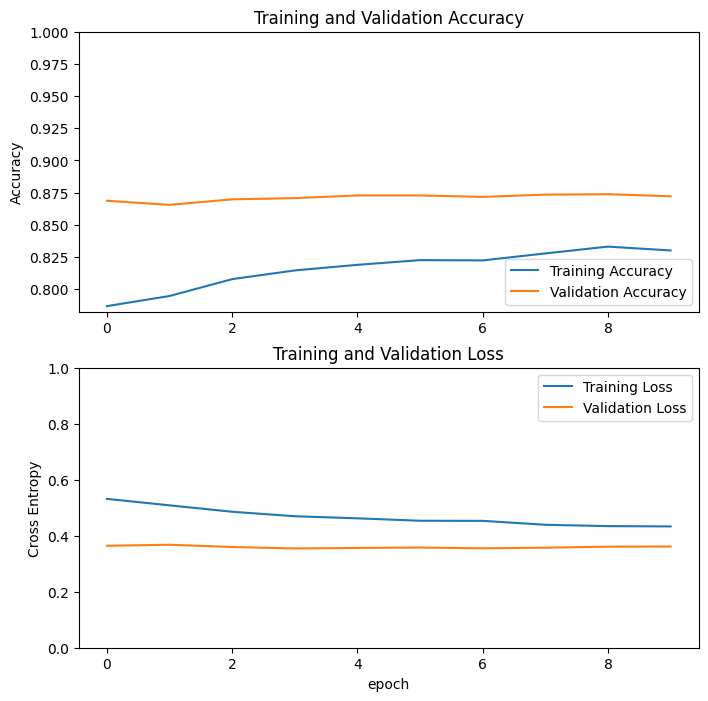

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  238


In [ ]:
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 210

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), 
              metrics=['accuracy', 'mse'])

In [ ]:
model.summary()


Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_10 (Rescaling)       (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 224, 224, 3)  7          ['rescaling_10[0][0]']           
 )                                                                                                
                                                                                       

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
946/946 [==============================] - 466s 480ms/step - loss: 0.9559 - accuracy: 0.6869 - mse: 0.2381 - val_loss: 0.5926 - val_accuracy: 0.8046 - val_mse: 0.1580
Epoch 11/15
946/946 [==============================] - 447s 472ms/step - loss: 0.5637 - accuracy: 0.7645 - mse: 0.1728 - val_loss: 0.3776 - val_accuracy: 0.8738 - val_mse: 0.1012
Epoch 12/15
946/946 [==============================] - 446s 472ms/step - loss: 0.5222 - accuracy: 0.7817 - mse: 0.1598 - val_loss: 0.3846 - val_accuracy: 0.8724 - val_mse: 0.1031
Epoch 13/15
946/946 [==============================] - 442s 468ms/step - loss: 0.4873 - accuracy: 0.7920 - mse: 0.1511 - val_loss: 0.3636 - val_accuracy: 0.8781 - val_mse: 0.0972
Epoch 14/15
946/946 [==============================] - 456s 482ms/step - loss: 0.4721 - accuracy: 0.7983 - mse: 0.1468 - val_loss: 1.0222 - val_accuracy: 0.5184 - val_mse: 0.3153
Epoch 15/15
946/946 [==============================] - 440s 465ms/step - loss: 0.4559 - accuracy: 0.8048 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

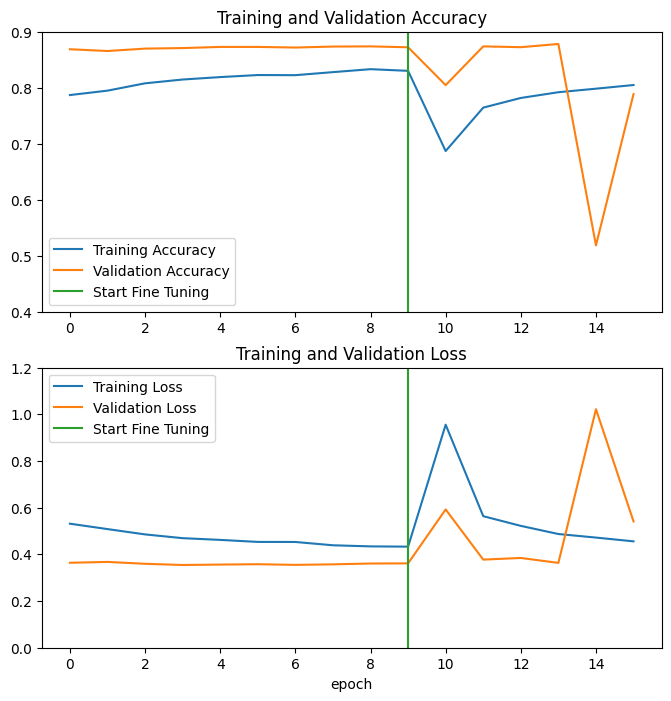

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 0.9])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_data)

6300/6300 [==============================] - 89s 14ms/step - loss: 0.5484 - accuracy: 0.7994 - mse: 0.1524


[0.5484290719032288, 0.7993651032447815, 0.15238308906555176]

##ResNet50

In [ ]:
early_stopp = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

inputs = tf.keras.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs,
)

base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="ResNet")

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              metrics=['accuracy', 'mse'])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [ ]:
initial_epochs = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs,
    callbacks=[early_stopp]
)

Epoch 1/10
946/946 [==============================] - 495s 509ms/step - loss: 0.3770 - accuracy: 0.8791 - mse: 0.0937 - val_loss: 0.4590 - val_accuracy: 0.8594 - val_mse: 0.1084
Epoch 2/10
946/946 [==============================] - 454s 480ms/step - loss: 0.3852 - accuracy: 0.8863 - mse: 0.0903 - val_loss: 0.3660 - val_accuracy: 0.8806 - val_mse: 0.0928
Epoch 3/10
946/946 [==============================] - 454s 479ms/step - loss: 0.3401 - accuracy: 0.8924 - mse: 0.0843 - val_loss: 0.4233 - val_accuracy: 0.8887 - val_mse: 0.0899
Epoch 4/10
946/946 [==============================] - 472s 499ms/step - loss: 0.3393 - accuracy: 0.8968 - mse: 0.0823 - val_loss: 0.4176 - val_accuracy: 0.8689 - val_mse: 0.0989
Epoch 5/10
946/946 [==============================] - 456s 483ms/step - loss: 0.3503 - accuracy: 0.8950 - mse: 0.0835 - val_loss: 0.4408 - val_accuracy: 0.9067 - val_mse: 0.0756
Epoch 6/10
946/946 [==============================] - 476s 503ms/step - loss: 0.3401 - accuracy: 0.8980 - mse:

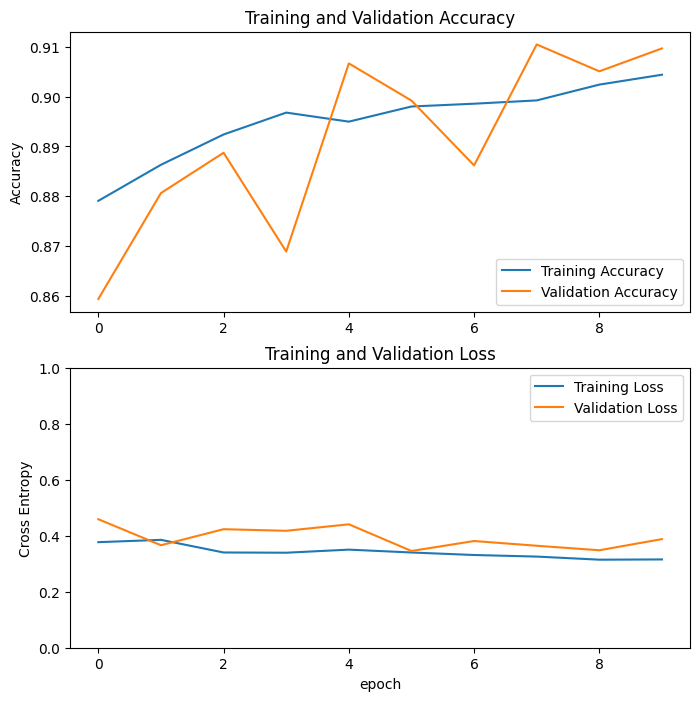

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100), 
              metrics=['accuracy', 'mse'])

In [ ]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                             

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
946/946 [==============================] - 471s 486ms/step - loss: 0.4802 - accuracy: 0.8758 - mse: 0.1012 - val_loss: 0.4962 - val_accuracy: 0.9014 - val_mse: 0.0823
Epoch 11/15
946/946 [==============================] - 462s 489ms/step - loss: 0.3432 - accuracy: 0.8908 - mse: 0.0856 - val_loss: 0.5221 - val_accuracy: 0.8830 - val_mse: 0.0906
Epoch 12/15
946/946 [==============================] - 502s 530ms/step - loss: 0.2987 - accuracy: 0.9005 - mse: 0.0775 - val_loss: 0.3972 - val_accuracy: 0.9000 - val_mse: 0.0801
Epoch 13/15
946/946 [==============================] - 483s 511ms/step - loss: 0.2945 - accuracy: 0.9006 - mse: 0.0772 - val_loss: 0.3250 - val_accuracy: 0.9049 - val_mse: 0.0734
Epoch 14/15
946/946 [==============================] - 465s 492ms/step - loss: 0.2764 - accuracy: 0.9028 - mse: 0.0739 - val_loss: 0.4410 - val_accuracy: 0.8949 - val_mse: 0.0870
Epoch 15/15
946/946 [==============================] - 477s 504ms/step - loss: 0.2676 - accuracy: 0.9080 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

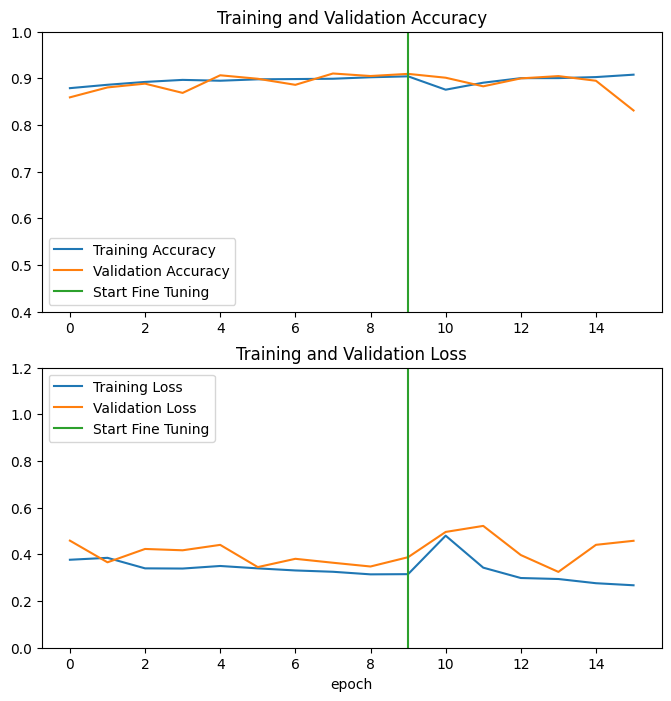

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_data)

6300/6300 [==============================] - 82s 13ms/step - loss: 0.4899 - accuracy: 0.8302 - mse: 0.1253


[0.4899497330188751, 0.8301587104797363, 0.12534837424755096]

##VGG19


In [ ]:
early_stopp = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

inputs = tf.keras.Input(shape=(224, 224, 3))

base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs,
)

base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="VGG19")

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
base_learning_rate = 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              metrics=['accuracy', 'mse'])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
initial_epochs = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs,
    callbacks=[early_stopp]
)

Epoch 1/10
946/946 [==============================] - 509s 525ms/step - loss: 0.5743 - accuracy: 0.8973 - mse: 0.0893 - val_loss: 0.5256 - val_accuracy: 0.9271 - val_mse: 0.0652
Epoch 2/10
946/946 [==============================] - 464s 490ms/step - loss: 0.6187 - accuracy: 0.9089 - mse: 0.0807 - val_loss: 0.5845 - val_accuracy: 0.9332 - val_mse: 0.0605
Epoch 3/10
946/946 [==============================] - 461s 487ms/step - loss: 0.6267 - accuracy: 0.9135 - mse: 0.0772 - val_loss: 0.7490 - val_accuracy: 0.9173 - val_mse: 0.0745
Epoch 4/10
946/946 [==============================] - 457s 483ms/step - loss: 0.6287 - accuracy: 0.9155 - mse: 0.0754 - val_loss: 0.6778 - val_accuracy: 0.9314 - val_mse: 0.0635
Epoch 5/10
946/946 [==============================] - 458s 484ms/step - loss: 0.6401 - accuracy: 0.9173 - mse: 0.0742 - val_loss: 0.6420 - val_accuracy: 0.9270 - val_mse: 0.0663
Epoch 6/10
946/946 [==============================] - 461s 487ms/step - loss: 0.6559 - accuracy: 0.9195 - mse:

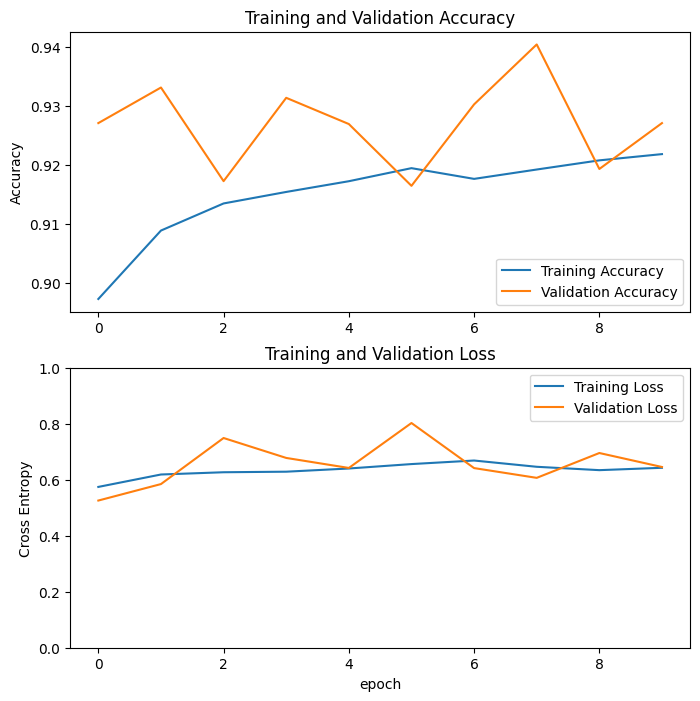

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [ ]:
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 17

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100), 
              metrics=['accuracy', 'mse'])

In [ ]:
model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
946/946 [==============================] - 494s 518ms/step - loss: 0.4734 - accuracy: 0.9254 - mse: 0.0657 - val_loss: 0.5525 - val_accuracy: 0.9224 - val_mse: 0.0696
Epoch 11/15
946/946 [==============================] - 477s 504ms/step - loss: 0.3421 - accuracy: 0.9321 - mse: 0.0582 - val_loss: 0.4477 - val_accuracy: 0.9208 - val_mse: 0.0691
Epoch 12/15
946/946 [==============================] - 475s 502ms/step - loss: 0.2603 - accuracy: 0.9380 - mse: 0.0511 - val_loss: 0.3080 - val_accuracy: 0.9332 - val_mse: 0.0574
Epoch 13/15
946/946 [==============================] - 474s 501ms/step - loss: 0.2205 - accuracy: 0.9418 - mse: 0.0478 - val_loss: 0.2298 - val_accuracy: 0.9467 - val_mse: 0.0449
Epoch 14/15
946/946 [==============================] - 476s 503ms/step - loss: 0.1903 - accuracy: 0.9464 - mse: 0.0435 - val_loss: 0.2299 - val_accuracy: 0.9390 - val_mse: 0.0487
Epoch 15/15
946/946 [==============================] - 475s 502ms/step - loss: 0.1671 - accuracy: 0.9499 

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

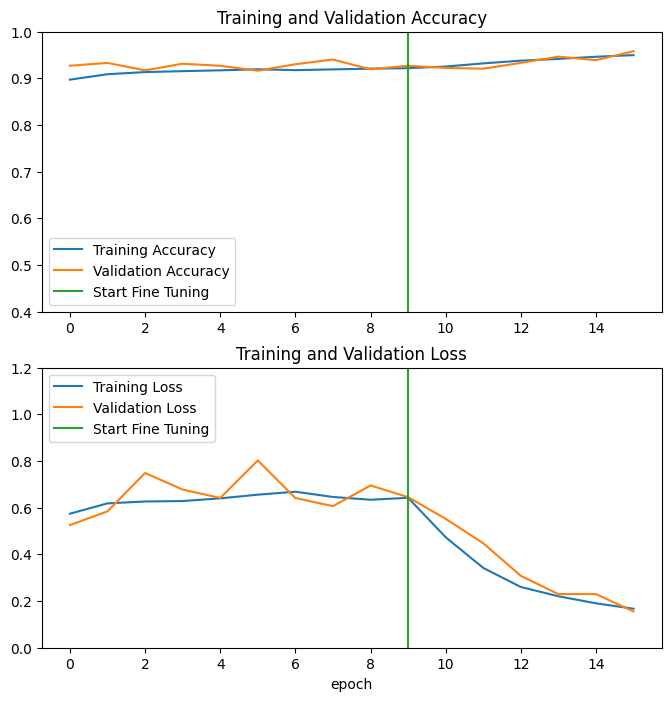

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_data)

6300/6300 [==============================] - 82s 13ms/step - loss: 0.1301 - accuracy: 0.9681 - mse: 0.0259


[0.13005872070789337, 0.9680952429771423, 0.025896696373820305]

In [ ]:
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['nowildfire', 'wildfire']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

<ipython-input-27-f18fd9c0408d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data)


Confusion Matrix
[[1353 1467]
 [1574 1906]]
Classification Report
              precision    recall  f1-score   support

  nowildfire       0.46      0.48      0.47      2820
    wildfire       0.57      0.55      0.56      3480

    accuracy                           0.52      6300
   macro avg       0.51      0.51      0.51      6300
weighted avg       0.52      0.52      0.52      6300



##InceptionV3

In [11]:
early_stopp = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

inputs = tf.keras.Input(shape=(299, 299, 3))

base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs,
)

base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="InceptionV3")

87910968/87910968 [==============================] - 5s 0us/step


In [12]:
base_learning_rate = 0.001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              metrics=['accuracy', 'mse'])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                       

In [14]:
initial_epochs = 10

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=initial_epochs,
    callbacks=[early_stopp]
)

Epoch 1/10
946/946 [==============================] - 850s 883ms/step - loss: 1.1164 - accuracy: 0.8738 - mse: 0.1144 - val_loss: 2.2334 - val_accuracy: 0.7737 - val_mse: 0.2093
Epoch 2/10
946/946 [==============================] - 763s 807ms/step - loss: 1.1577 - accuracy: 0.8873 - mse: 0.1039 - val_loss: 1.3540 - val_accuracy: 0.9002 - val_mse: 0.0932
Epoch 3/10
946/946 [==============================] - 749s 791ms/step - loss: 1.0573 - accuracy: 0.8935 - mse: 0.0977 - val_loss: 1.1707 - val_accuracy: 0.9060 - val_mse: 0.0877
Epoch 4/10
946/946 [==============================] - 749s 792ms/step - loss: 1.0550 - accuracy: 0.8975 - mse: 0.0943 - val_loss: 0.9529 - val_accuracy: 0.9171 - val_mse: 0.0771
Epoch 5/10
946/946 [==============================] - 755s 797ms/step - loss: 0.9974 - accuracy: 0.9007 - mse: 0.0920 - val_loss: 1.0799 - val_accuracy: 0.8935 - val_mse: 0.0970
Epoch 6/10
946/946 [==============================] - 749s 792ms/step - loss: 1.0039 - accuracy: 0.8994 - mse:

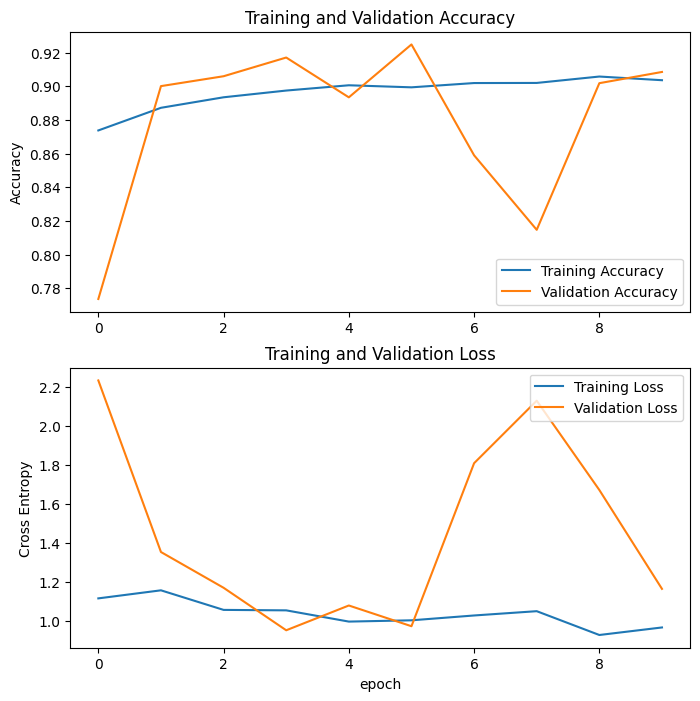

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [18]:
base_model.trainable = True

In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 275

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [20]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100), 
              metrics=['accuracy', 'mse'])

In [21]:
model.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                       

In [22]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

In [23]:
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/15
946/946 [==============================] - 778s 811ms/step - loss: 1.5764 - accuracy: 0.8853 - mse: 0.1077 - val_loss: 1.7132 - val_accuracy: 0.8622 - val_mse: 0.1275
Epoch 11/15
946/946 [==============================] - 755s 798ms/step - loss: 1.0381 - accuracy: 0.8982 - mse: 0.0937 - val_loss: 2.3424 - val_accuracy: 0.7773 - val_mse: 0.2049
Epoch 12/15
946/946 [==============================] - 759s 802ms/step - loss: 0.9225 - accuracy: 0.9038 - mse: 0.0880 - val_loss: 1.3995 - val_accuracy: 0.8557 - val_mse: 0.1301
Epoch 13/15
946/946 [==============================] - 753s 796ms/step - loss: 0.8601 - accuracy: 0.9036 - mse: 0.0873 - val_loss: 1.0092 - val_accuracy: 0.9232 - val_mse: 0.0730
Epoch 14/15
946/946 [==============================] - 751s 794ms/step - loss: 0.7754 - accuracy: 0.9068 - mse: 0.0843 - val_loss: 4.8048 - val_accuracy: 0.6013 - val_mse: 0.3757
Epoch 15/15
946/946 [==============================] - 742s 784ms/step - loss: 0.7358 - accuracy: 0.9073 

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

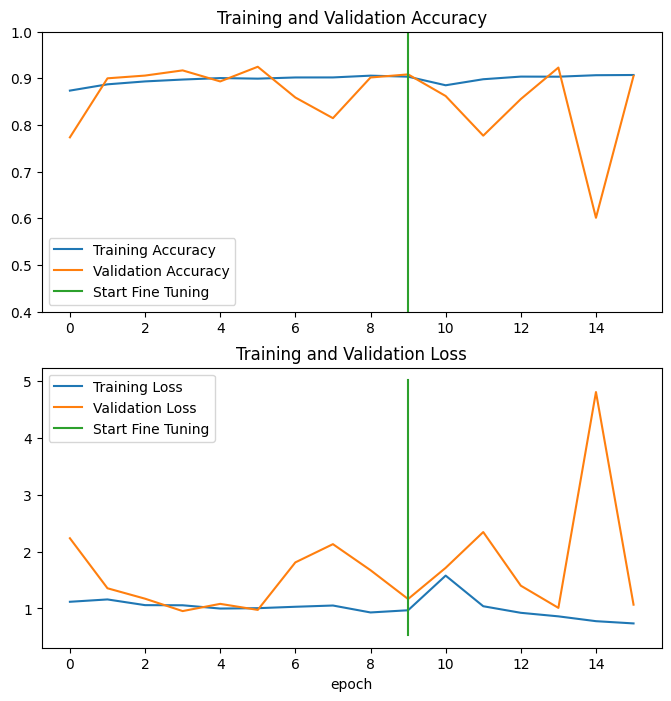

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.2])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
model.evaluate(test_data)

6300/6300 [==============================] - 101s 16ms/step - loss: 0.9101 - accuracy: 0.9152 - mse: 0.0774


[0.9101216793060303, 0.915238082408905, 0.0774443969130516]